
# Introduction to Classification.

    Notebook version: 1.0 (Oct 6, 2016)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
            Jerónimo Arenas García (jarenas@tsc.uc3m.es)

    Changes: v.1.0 - First version. Extracted from a former notebook on K-NN


In [3]:
# To visualize plots in the notebook
%matplotlib inline 

# Import some libraries that will be necessary for working with data and displaying plots
import csv     # To read csv files
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from sklearn import neighbors, datasets

## 1. The Classification problem

In a generic classification problem, we are given an observation vector ${\bf x}\in \mathbb{R}^N$ which is known to belong to one and only one *category* or *class*, $y$, in the set ${\mathcal Y} = \{0, 1, \ldots, M-1\}$. The goal of a classifier system is to predict the value of $y$ based on ${\bf x}$.

To design the classifier, we are given a collection of labelled observations ${\mathcal S} = \{({\bf x}^{(k)}, y^{(k)})\}_{k=1}^K$ where, for each observation ${\bf x}^{(k)}$, the value of its true category, $y^{(k)}$, is known.

### 1.1 Binary Classification

We will focus in binary classification problems, where the label set is binary, ${\mathcal Y} = \{0, 1\}$. Despite its simplicity, this is the most frequent case. Many multi-class classification problems are usually solved by decomposing them into a collection of binary problems.

### 1.2. The i.i.d. assumption.

The classification algorithms, as many other machine learning algorithms, are based on two major underlying hypothesis:

   - All samples in dataset ${\mathcal S}$ are i.i.d. (independent and identically distributed), i.e., all samples are independent outcomes of an unknown distribution $p({\bf x}, y)$.
   - For any test data, the tuple formed by the input sample and its unknown class, $({\bf x}, y)$, is an independent outcome of the *same* distribution.
   
These two assumptions are essential to have some guarantees that a classifier design based on ${\mathcal S}$ has a good perfomance when applied to new input samples. Note that, despite assuming the existence of an underlying distribution, such distribution is unknown: otherwise, we could ignore ${\mathcal S}$ and apply classic decision theory to find the optimal predictor based on  $p({\bf x}, y)$.


## 2. A simple classification problem: the Iris dataset

(Iris dataset presentation is based on this <a href=http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/> Tutorial </a> by <a href=http://machinelearningmastery.com/about/> Jason Brownlee</a>) 

As an illustration, consider the <a href = http://archive.ics.uci.edu/ml/datasets/Iris> Iris dataset </a>, taken from the <a href=http://archive.ics.uci.edu/ml/> UCI Machine Learning repository </a>. Quoted from the dataset description:

> This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. [...] One class is linearly separable from the other 2; the latter are NOT linearly separable from each other. 

The *class* is the species, which is one of *setosa*, *versicolor* or *virginica*. Each instance contains 4 measurements of given flowers: sepal length, sepal width, petal length and petal width, all in centimeters. 


In [4]:
# Taken from Jason Brownlee notebook.
with open('datasets/iris.data', 'rb') as csvfile:
	lines = csv.reader(csvfile)
	for row in lines:
		print ', '.join(row)

5.1, 3.5, 1.4, 0.2, Iris-setosa
4.9, 3.0, 1.4, 0.2, Iris-setosa
4.7, 3.2, 1.3, 0.2, Iris-setosa
4.6, 3.1, 1.5, 0.2, Iris-setosa
5.0, 3.6, 1.4, 0.2, Iris-setosa
5.4, 3.9, 1.7, 0.4, Iris-setosa
4.6, 3.4, 1.4, 0.3, Iris-setosa
5.0, 3.4, 1.5, 0.2, Iris-setosa
4.4, 2.9, 1.4, 0.2, Iris-setosa
4.9, 3.1, 1.5, 0.1, Iris-setosa
5.4, 3.7, 1.5, 0.2, Iris-setosa
4.8, 3.4, 1.6, 0.2, Iris-setosa
4.8, 3.0, 1.4, 0.1, Iris-setosa
4.3, 3.0, 1.1, 0.1, Iris-setosa
5.8, 4.0, 1.2, 0.2, Iris-setosa
5.7, 4.4, 1.5, 0.4, Iris-setosa
5.4, 3.9, 1.3, 0.4, Iris-setosa
5.1, 3.5, 1.4, 0.3, Iris-setosa
5.7, 3.8, 1.7, 0.3, Iris-setosa
5.1, 3.8, 1.5, 0.3, Iris-setosa
5.4, 3.4, 1.7, 0.2, Iris-setosa
5.1, 3.7, 1.5, 0.4, Iris-setosa
4.6, 3.6, 1.0, 0.2, Iris-setosa
5.1, 3.3, 1.7, 0.5, Iris-setosa
4.8, 3.4, 1.9, 0.2, Iris-setosa
5.0, 3.0, 1.6, 0.2, Iris-setosa
5.0, 3.4, 1.6, 0.4, Iris-setosa
5.2, 3.5, 1.5, 0.2, Iris-setosa
5.2, 3.4, 1.4, 0.2, Iris-setosa
4.7, 3.2, 1.6, 0.2, Iris-setosa
4.8, 3.1, 1.6, 0.2, Iris-setosa
5.4, 3.4

Next, we will split the data into a training dataset, that will be used to learn the classification model, and a test dataset that we can use to evaluate its the accuracy.

We first need to convert the flower measures that were loaded as strings into numbers that we can work with. Next we need to split the data set **randomly** into train and datasets. A ratio of 67/33 for train/test will be used.

The code fragment below defines a function `loadDataset` that loads the data in a CSV with the provided filename and splits it randomly into train and test datasets using the provided split ratio.



In [5]:
# Adapted from a notebook by Jason Brownlee
def loadDataset(filename, split):
    xTrain = []
    cTrain = []
    xTest = []
    cTest = []

    with open(filename, 'rb') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
    for i in range(len(dataset)-1):
        for y in range(4):
            dataset[i][y] = float(dataset[i][y])
        item = dataset[i]
        if random.random() < split:
            xTrain.append(item[0:-1])
            cTrain.append(item[-1])
        else:
            xTest.append(item[0:-1])
            cTest.append(item[-1])
    return xTrain, cTrain, xTest, cTest

We can use this function to get a data split. Note that, because of the way samples are assigned to the train or test datasets, the number of samples in each partition will differ if you run the code several times.

In [10]:
xTrain_all, cTrain_all, xTest_all, cTest_all = loadDataset('datasets/iris.data', 0.67)
nTrain_all = len(xTrain_all)
nTest_all = len(xTest_all)
print 'Train: ' + str(nTrain_all)
print 'Test: ' + str(nTest_all)


Train: 109
Test: 41


To get some intuition about this four dimensional dataset we can plot 2-dimensional projections taking only two variables each time.

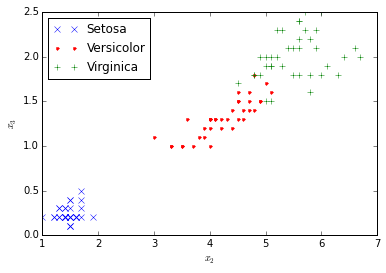

In [13]:
i = 2 # Try 0,1,2,3
j = 3 # Try 0,1,2,3 with j!=i

# Take coordinates for each class separately
xiSe = [xTrain_all[n][i] for n in range(nTrain_all) if cTrain_all[n]=='Iris-setosa']
xjSe = [xTrain_all[n][j] for n in range(nTrain_all) if cTrain_all[n]=='Iris-setosa']
xiVe = [xTrain_all[n][i] for n in range(nTrain_all) if cTrain_all[n]=='Iris-versicolor']
xjVe = [xTrain_all[n][j] for n in range(nTrain_all) if cTrain_all[n]=='Iris-versicolor']
xiVi = [xTrain_all[n][i] for n in range(nTrain_all) if cTrain_all[n]=='Iris-virginica']
xjVi = [xTrain_all[n][j] for n in range(nTrain_all) if cTrain_all[n]=='Iris-virginica']

plt.plot(xiSe, xjSe,'bx', label='Setosa')
plt.plot(xiVe, xjVe,'r.', label='Versicolor')
plt.plot(xiVi, xjVi,'g+', label='Virginica')
plt.xlabel('$x_' + str(i) + '$')
plt.ylabel('$x_' + str(j) + '$')
plt.legend(loc='best')

In the following, we will design a classifier to separate classes "Versicolor" and "Virginica" using $x_0$ and $x_1$ only. To do so, we build a training set with samples from these categories, and a bynary label $y^{(k)} = 1$ for samples in class "Virginica", and $0$ for "Versicolor" data.

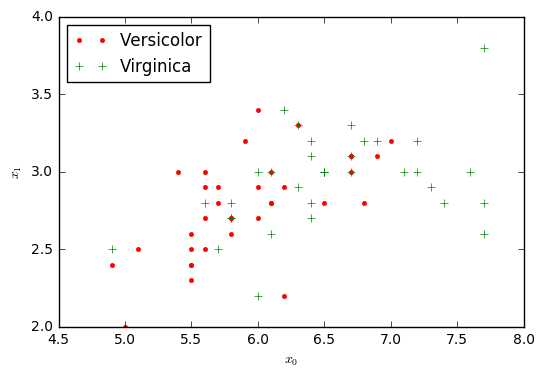

In [9]:
# Select two classes
c0 = 'Iris-versicolor' 
c1 = 'Iris-virginica'

# Select two coordinates
ind = [0, 1]

# Take training test
X_tr = np.array([[xTrain_all[n][i] for i in ind] for n in range(nTrain_all) 
                  if cTrain_all[n]==c0 or cTrain_all[n]==c1])
C_tr = [cTrain_all[n] for n in range(nTrain_all) 
          if cTrain_all[n]==c0 or cTrain_all[n]==c1]
Y_tr = np.array([int(c==c1) for c in C_tr])
n_tr = len(X_tr)

# Take test set
X_tst = np.array([[xTest_all[n][i] for i in ind] for n in range(nTest_all) 
                 if cTest_all[n]==c0 or cTest_all[n]==c1])
C_tst = [cTest_all[n] for n in range(nTest_all) 
         if cTest_all[n]==c0 or cTest_all[n]==c1]
Y_tst = np.array([int(c==c1) for c in C_tst])
n_tst = len(X_tst)

# Separate components of x into different arrays (just for the plots)
x0c0 = [X_tr[n][0] for n in range(n_tr) if Y_tr[n]==0]
x1c0 = [X_tr[n][1] for n in range(n_tr) if Y_tr[n]==0]
x0c1 = [X_tr[n][0] for n in range(n_tr) if Y_tr[n]==1]
x1c1 = [X_tr[n][1] for n in range(n_tr) if Y_tr[n]==1]

# Scatterplot.
labels = {'Iris-setosa': 'Setosa', 
          'Iris-versicolor': 'Versicolor',
          'Iris-virginica': 'Virginica'}
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')


## 3. A Baseline Classifier: Maximum A Priori.

For the selected data set, we have two clases and a dataset with the following class proportions:

In [10]:
print 'Class 0 (' + c0 + '): ' + str(n_tr - sum(Y_tr)) + ' samples'
print 'Class 1 (' + c1 + '): ' + str(sum(Y_tr)) + ' samples'

Class 0 (Iris-versicolor): 35 samples
Class 1 (Iris-virginica): 34 samples


The maximum a priori classifier assigns any sample ${\bf x}$ to the most frequent class in the training set. Therefore, the class prediction $y$ for any sample ${\bf x}$ is

In [11]:
y = int(2*sum(Y_tr) > n_tr)
print 'y = ' + str(y) + ' (' + (c1 if y==1 else c0) + ')'

y = 0 (Iris-versicolor)


The error rate for this baseline classifier is:

In [12]:
# Training and test error arrays
E_tr = (Y_tr != y)
E_tst = (Y_tst != y)

# Error rates
pe_tr = float(sum(E_tr)) / n_tr
pe_tst = float(sum(E_tst)) / n_tst
print 'Pe(train) = ' + str(pe_tr)
print 'Pe(test) = ' + str(pe_tst)

Pe(train) = 0.492753623188
Pe(test) = 0.516129032258


The error rate of the baseline classifier is a simple benchmark for classification. Since the maximum a priori decision is independent on the observation, ${\bf x}$, any classifier based on ${\bf x}$ should have a better (or, at least, not worse) performance than the baseline classifier.

## 3. Parametric vs non-parametric classification.

Most classification algorithms can be fitted to one of two categories:

1. Parametric classifiers: to classify any input sample ${\bf x}$, the classifier applies some function $f_{\bf w}({\bf x})$ which depends on some parameters ${\bf w}$. The training dataset is used to estimate ${\bf w}$. Once the parameter has been estimated, the training data is no longer needed to classify new inputs.

2. Non-parametric classifiers: the classifier decision for any input ${\bf x}$ depend on the training data in a direct manner. The training data must be preserve to classify new data.

